In [8]:
# %matplotlib widget
from micromlgen import port

import os
from platform import python_version
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import warnings
from scipy.stats import f_oneway

warnings.filterwarnings("ignore")
assert python_version() == "3.10.15"
#assert np.__version__ == "2.0.2"
#assert pd.__version__ == "2.2.3"

 
#Function to extract the training data
def get_training(original_path):
    
    # Load the training data csv file into a dataframe. 
    df = pd.read_csv(os.path.join(original_path,'train.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'train_extracted')):
        os.makedirs(os.path.join(original_path,'train_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):    
        d,r = librosa.load(os.path.join(original_path,'Train',str(audio_files[i])),mono=True)
        np.save(os.path.join(original_path, 'train_extracted',str(audio_files[i])+'.npy'),d)   
            
#Function to extract the testing data
def get_testing(original_path):

    # Load the test data csv file into a dataframe.
    df = pd.read_csv(os.path.join(original_path,'test_idx.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'test_extracted')):
        os.makedirs(os.path.join(original_path,'test_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):   
        d,r = librosa.load(os.path.join(original_path,'Test',str(audio_files[i])),mono=True)
        np.save(os.path.join(original_path, 'test_extracted',str(audio_files[i])+'.npy'),d)      
          
#Funtion to retrieve the labels of training data
def get_labels(original_path,csv_file):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Return the labels.
  labels = np.array(df['keyword'])

  return labels

#Funtion to get the features of the data
def get_all_features(original_path, csv_file, extracted_folder):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))
  df.fillna(0, inplace=True)

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  all_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate Root Mean Square Error.
    rmse= librosa.feature.rms(y=audio_file_data, frame_length=441)

    # Calculate Zero Crossing Rate.
    zcr =librosa.feature.zero_crossing_rate(audio_file_data, frame_length=441)

    # Calculate and append statistic features for all the above data features.
    # addList = np.concatenate((np.mean(mfcc_data, axis=1),np.median(mfcc_data,axis=1),np.std(mfcc_data, axis=1),skew(mfcc_data, axis=1),kurtosis(mfcc_data, axis=1),np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(chroma_stft)),np.atleast_1d(np.median(chroma_stft)),np.atleast_1d(np.std(chroma_stft)),np.atleast_1d(skew(chroma_stft)),np.atleast_1d(kurtosis(chroma_stft)),np.atleast_1d(np.mean(spec_cent)),np.atleast_1d(np.median(spec_cent)),np.atleast_1d(np.std(spec_cent)),np.atleast_1d(skew(spec_cent,axis=1)),np.atleast_1d(kurtosis(spec_cent,axis=1)),np.atleast_1d(np.mean(spec_bw)),np.atleast_1d(np.median(spec_bw)),np.atleast_1d(np.std(spec_bw)),np.atleast_1d(skew(spec_bw,axis=1)),np.atleast_1d(kurtosis(spec_bw,axis=1)),np.atleast_1d(np.mean(rolloff)),np.atleast_1d(np.median(rolloff)),np.atleast_1d(np.std(rolloff)),np.atleast_1d(skew(rolloff,axis=1)),np.atleast_1d(kurtosis(rolloff,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1)),np.amax(mfcc_data, axis=1),np.amin(mfcc_data, axis=1)))
    addList = np.concatenate((np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1))))
    all_features.append(addList)
     

  return all_features

#Funtion to get the features of the data
def get_best_features(original_path, csv_file, extracted_folder):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))
  df.fillna(0, inplace=True)

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  all_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate Root Mean Square Error.
    rmse= librosa.feature.rms(y=audio_file_data, frame_length=441)

    # Calculate Zero Crossing Rate.
    zcr =librosa.feature.zero_crossing_rate(audio_file_data, frame_length=441)

    # Calculate and append statistic features for all the above data features.
    # addList = np.concatenate((np.mean(mfcc_data, axis=1),np.median(mfcc_data,axis=1),np.std(mfcc_data, axis=1),skew(mfcc_data, axis=1),kurtosis(mfcc_data, axis=1),np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(chroma_stft)),np.atleast_1d(np.median(chroma_stft)),np.atleast_1d(np.std(chroma_stft)),np.atleast_1d(skew(chroma_stft)),np.atleast_1d(kurtosis(chroma_stft)),np.atleast_1d(np.mean(spec_cent)),np.atleast_1d(np.median(spec_cent)),np.atleast_1d(np.std(spec_cent)),np.atleast_1d(skew(spec_cent,axis=1)),np.atleast_1d(kurtosis(spec_cent,axis=1)),np.atleast_1d(np.mean(spec_bw)),np.atleast_1d(np.median(spec_bw)),np.atleast_1d(np.std(spec_bw)),np.atleast_1d(skew(spec_bw,axis=1)),np.atleast_1d(kurtosis(spec_bw,axis=1)),np.atleast_1d(np.mean(rolloff)),np.atleast_1d(np.median(rolloff)),np.atleast_1d(np.std(rolloff)),np.atleast_1d(skew(rolloff,axis=1)),np.atleast_1d(kurtosis(rolloff,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1)),np.amax(mfcc_data, axis=1),np.amin(mfcc_data, axis=1)))
    addList = np.concatenate((np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1))))
    all_features.append(addList)
     

  return all_features

#Function to use Random Forest classifier
def random_forest(X_train,Y_train,X_test):

  # Intialize Random Forest classifier with number of trees as 800.
  random_forest = RandomForestClassifier(n_estimators = 800, class_weight='balanced')

  # Fit Training Dataset.
  random_forest.fit(X_train, Y_train)

  # Predict and return labels.
  return random_forest.predict(X_test)

#Funtion to standardize the features
def standardize_features(X_train,X_test):

  # Initialize standard scalar with zero mean
  sc = StandardScaler(with_mean=False)

  # Fit and transform the Training Dataset.
  X_train= sc.fit_transform(X_train)

  # Transform the testing set.
  X_test = sc.transform(X_test)
  
  return X_train,X_test
#Function to plot the confusion matrix
def plot_confusion_matrix(y_true,y_pred,label_names,classifier):
    
    # Calculate the confusion matrix using the expected and predicted values.
    #confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    # print(y_true)
    # print(y_pred)
    confusion_mat = confusion_matrix(y_true,y_pred,labels=label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(5,4))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputs", fontsize=10)
    plt.ylabel("Actual Outputs", fontsize=10)
    plt.title("Confusion Matrix of "+ classifier + " classifier",fontsize=12)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names)
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='10')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='12')
            
    # Show the plot
    plt.show()
#Function to perform cross validation
def cross_validate(X_train,Y_train,data_rep):

 # Choose classifiers based on the Data Representation.
 if data_rep=="Forest":
    clf = random_forest
    classifier="Random Forest" 
 sc = StandardScaler()
 X_train = sc.fit_transform(X_train)
 


 # Create a Stratified KFold with 5 splits.
 k_fold = StratifiedKFold(n_splits=5,shuffle=True)

 # Create two empty lists to keep track of accuracies for plotting and predictions for confusion matrix.
 accuracies_clf = np.array([])
 predictions_clf = np.array([])
 actual_predictions = np.array([])

 # Split the Dataset and Loop through each fold.
 for train_index, test_index in k_fold.split(X_train,Y_train):

    # Split the Dataset into Training and Validation.
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]    

    # Fit and Predict the current fold using the classifier.
    pred = clf(x_train,y_train,x_test)

    # Append the accuracies and predictions.
    predictions_clf = np.append(predictions_clf,pred)
    actual_predictions = np.append(actual_predictions,y_test)
    accuracies_clf = np.append(accuracies_clf,accuracy_score(pred,y_test))
    
 # Plot the confusion matrix for the classifier.
 plot_confusion_matrix(actual_predictions,predictions_clf,label_names,classifier)
 
 fig2 = plt.figure(figsize=(5,4))  
 # Plot the accuracy of the classifier for different folds
 plt.plot([1,2,3,4,5],accuracies_clf)
 plt.xticks(np.arange(1,5,1))
 plt.xlabel("5-Fold CV")
 plt.ylabel("Accuracy")
 plt.show() 

 # Calculate and print the accuracy range with 99% confidence interval
 accuracy_clf= accuracy_score(predictions_clf,actual_predictions)
 radius_clf = 2.58 * np.sqrt(accuracy_clf*(1-accuracy_clf)/len(predictions_clf))
 accuracy_clf_min =  (accuracy_clf - radius_clf)
 accuracy_clf_max =  (accuracy_clf + radius_clf)

 print('\n\n Accuracy of '+ classifier +' on Validation Dataset is ' + str(accuracy_clf))
 print('\n At 99% Confidence Interval :')
 print('\n The Accuracy of ' + classifier + ' is likely between ' + str(accuracy_clf_min) + ' and ' + str(accuracy_clf_max))




Extract Features

-----------------------------Training data extracted--------------------------


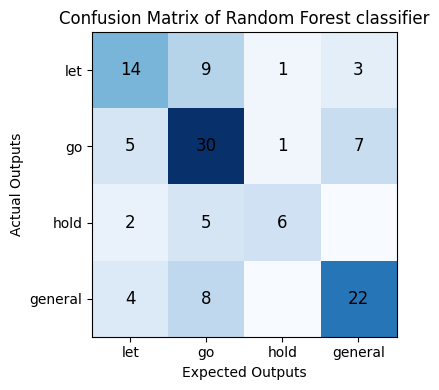

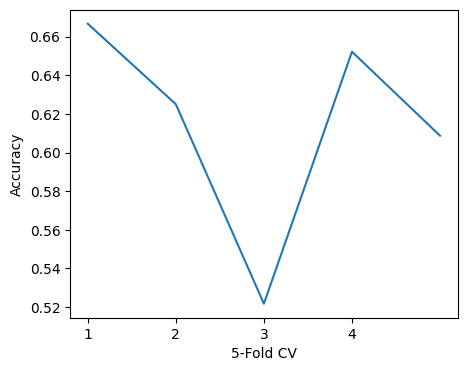



 Accuracy of Random Forest on Validation Dataset is 0.6153846153846154

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.49934309283014694 and 0.7314261379390838


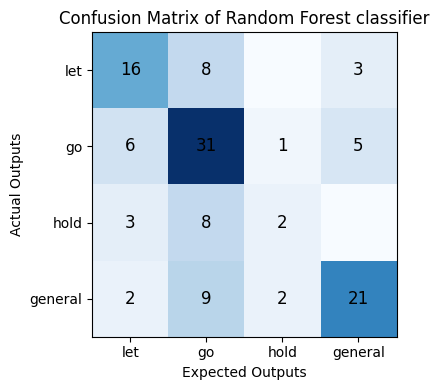

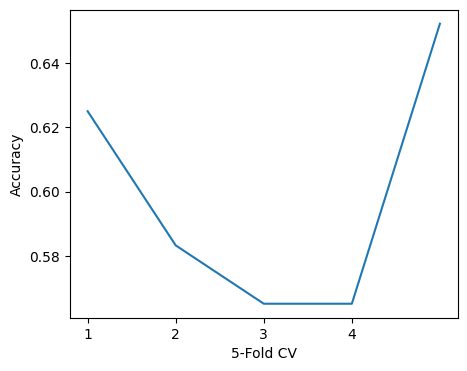



 Accuracy of Random Forest on Validation Dataset is 0.5982905982905983

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.4813571216239432 and 0.7152240749572534


In [10]:
label_names=['let', 'go','hold','general']

# Set the path to the unfiltered dataset
original_path = os.path.join("/home/lab2208/Documents/EE502/chapter4/Key-Word-Detection-using-Random-Forest/DatasetV2")
get_training(original_path)
print("-----------------------------Training data extracted--------------------------")
get_testing(original_path)

X_train = get_all_features(original_path,'train.csv','train_extracted')
X_test = get_all_features(original_path,'test_idx.csv','test_extracted')
Y_train = get_labels(original_path,'train.csv')
Y_test = get_labels(original_path,'test_idx.csv')
cross_validate(X_train,Y_train,"Forest") 

# Set the path path to the filtered dataset
original_path = os.path.join("/home/lab2208/Documents/EE502/chapter4/Key-Word-Detection-using-Random-Forest/DatasetV2_F")
get_training(original_path)
get_testing(original_path)
X_train_F = get_all_features(original_path,'train.csv','train_extracted')
X_test_F = get_all_features(original_path,'test_idx.csv','test_extracted')
Y_train_F = get_labels(original_path,'train.csv')
Y_test_F = get_labels(original_path,'test_idx.csv')
cross_validate(X_train_F,Y_train_F,"Forest")

In [11]:
print(os.listdir('DatasetV2/Train'))
try:
    x = librosa.load('/home/lab2208/Documents/EE502/chapter4/Key-Word-Detection-using-Random-Forest/DatasetV2/Train/marcy-50_let.wav', mono=True)
    print(f"Audio file loaded successfully: {x[0].shape}")
except Exception as e:
    print(f"Error loading audio file: {e}")
    
try:
    x2 = librosa.load('/home/lab2208/Documents/EE502/chapter4/Key-Word-Detection-using-Random-Forest/DatasetV2/train/marcy-50_let.wav', mono=True)
except Exception as e:
    print(f"Error loading audio file: {e}")


['marcy-50_let.wav', 'elena-15_let.wav', 'valerie-497_go.wav', 'markus-208_go.wav', 'angie-157_go.wav', 'angie-81_go.wav', 'cow-150_go.wav', 'big-51_hold.wav', 'angie-158_go.wav', 'irene-45_let.wav', 'valerie-277_go.wav', 'markus-25_let.wav', 'angie-69_general006.wav', 'cow-3_general003.wav', 'valerie-106_go.wav', 'angie-135_general005.wav', 'angie-69_general002.wav', 'elena-78_go.wav', 'angie-116_hold.wav', 'markus-54_go.wav', 'wario-54_let.wav', 'cow-11_general002.wav', 'angie-120_hold.wav', 'elena-9_let.wav', 'marcy-34_go.wav', 'wario-44_hold.wav', 'wario-39_let.wav', 'angie-151_go.wav', 'cow-11_general005.wav', 'angie-69_let.wav', 'angie-135_general008.wav', 'markus-9_let.wav', 'angie-69_general001.wav', 'cow-3_general002.wav', 'markus-460_go.wav', 'cow-11_general001.wav', 'valerie-665_go.wav', 'cow-54_go.wav', 'wario-11_hold.wav', 'big-22_go.wav', 'markus-352_hold.wav', 'leonardo-9_go.wav', 'angie-151_let.wav', 'angie-135_general003.wav', 'angie-69_general008.wav', 'angie-69_gener

In [12]:
#Do the ANOVA test

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train)):
        if Y_train[i] == label_names[0]:
            feat0.append(X_train[i])
        if Y_train[i] == label_names[1]:
            feat1.append(X_train[i])
        if Y_train[i] == label_names[2]:
            feat2.append(X_train[i])
        if Y_train[i] == label_names[3]:
            feat3.append(X_train[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train_F)):
        if Y_train_F[i] == label_names[0]:
            feat0.append(X_train_F[i])
        if Y_train_F[i] == label_names[1]:
            feat1.append(X_train_F[i])
        if Y_train_F[i] == label_names[2]:
            feat2.append(X_train_F[i])
        if Y_train_F[i] == label_names[3]:
            feat3.append(X_train_F[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train, Y_train)
importances = clf.feature_importances_
print(importances)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train_F, Y_train_F)
importances = clf.feature_importances_
print(importances)

[1.37930653e-06 1.69265569e-07 5.56353304e-10 1.40562511e-04
 2.39317765e-04 8.50178184e-05 2.25527218e-04 1.33172487e-02
 4.07491759e-04 1.73897002e-07]
[1.68827018e-06 9.84848078e-08 3.48017700e-09 4.82493221e-05
 3.42942334e-04 4.73521020e-04 2.21732522e-03 2.50667965e-02
 8.75390077e-04 7.47726179e-07]
[0.09538571 0.10426846 0.14198513 0.11649692 0.08807594 0.09798609
 0.06224245 0.09784504 0.09120247 0.1045118 ]
[0.09260594 0.1181306  0.13677985 0.11040299 0.09339182 0.08212651
 0.05992278 0.09274756 0.08961041 0.12428154]


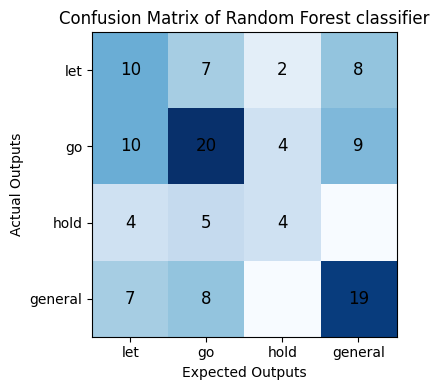

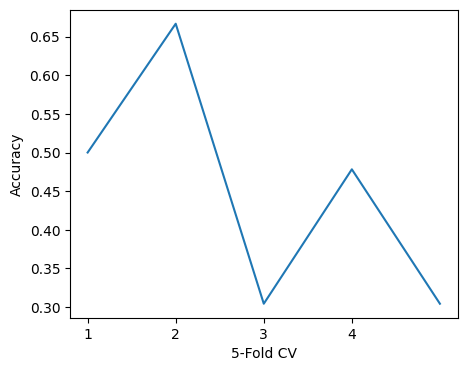



 Accuracy of Random Forest on Validation Dataset is 0.452991452991453

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.33425916545820117 and 0.5717237405247049


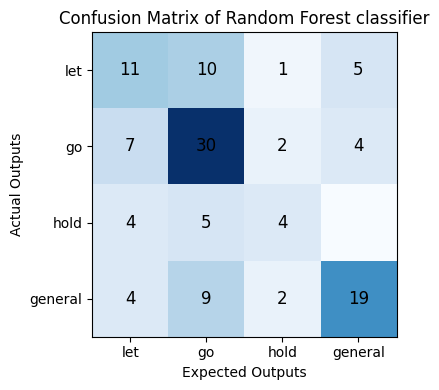

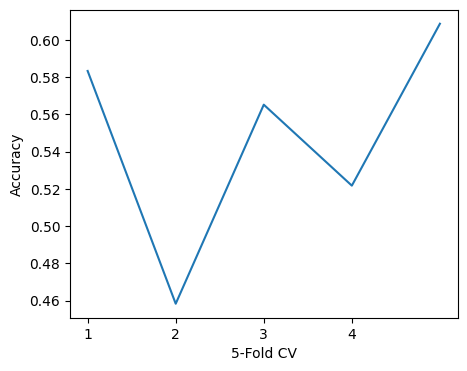



 Accuracy of Random Forest on Validation Dataset is 0.5470085470085471

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 0.42827625947529524 and 0.6657408345417989
[1.69265569e-07 5.56353304e-10 1.40562511e-04 4.07491759e-04
 1.73897002e-07]
[9.84848078e-08 3.48017700e-09 4.82493221e-05 8.75390077e-04
 7.47726179e-07]
[0.21226119 0.23055731 0.20441758 0.17522257 0.17754136]
[0.22323366 0.21128091 0.21501337 0.16015417 0.19031789]


In [13]:
label_names=['let', 'go','hold','general']
# Set the path to the unfiltered dataset
original_path = os.path.join("DatasetV2")
get_training(original_path)
get_testing(original_path)
X_train = get_best_features(original_path,'train.csv','train_extracted')
X_test = get_best_features(original_path,'test_idx.csv','test_extracted')
Y_train = get_labels(original_path,'train.csv')
Y_test = get_labels(original_path,'test_idx.csv')
cross_validate(X_train,Y_train,"Forest") 

# Set the path path to the filtered dataset
original_path = os.path.join("DatasetV2_F")
get_training(original_path)
get_testing(original_path)
X_train_F = get_best_features(original_path,'train.csv','train_extracted')
X_test_F = get_best_features(original_path,'test_idx.csv','test_extracted')
Y_train_F = get_labels(original_path,'train.csv')
Y_test_F = get_labels(original_path,'test_idx.csv')
cross_validate(X_train_F,Y_train_F,"Forest")

#Do the ANOVA test

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train)):
        if Y_train[i] == label_names[0]:
            feat0.append(X_train[i])
        if Y_train[i] == label_names[1]:
            feat1.append(X_train[i])
        if Y_train[i] == label_names[2]:
            feat2.append(X_train[i])
        if Y_train[i] == label_names[3]:
            feat3.append(X_train[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

feat0 = list()
feat1 = list()
feat2 = list()
feat3 = list()

for i in range(len(Y_train_F)):
        if Y_train_F[i] == label_names[0]:
            feat0.append(X_train_F[i])
        if Y_train_F[i] == label_names[1]:
            feat1.append(X_train_F[i])
        if Y_train_F[i] == label_names[2]:
            feat2.append(X_train_F[i])
        if Y_train_F[i] == label_names[3]:
            feat3.append(X_train_F[i])
                    
stat, p = f_oneway(feat0,feat1,feat2,feat3)

print(p)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train, Y_train)
importances = clf.feature_importances_
print(importances)

clf = RandomForestClassifier(n_estimators = 800, class_weight='balanced')
clf.fit(X_train_F, Y_train_F)
importances = clf.feature_importances_
print(importances)

In [14]:
#Find average accuracy per estimator
import pickle

bestacc = 0
bestn_est = 0
recacc = list()
numb_itr = 50
max_est = 100
unlock = True

for c in range(1,max_est):
    aveacc = 0
    
    for n in range(numb_itr):
        clf = RandomForestClassifier(n_estimators = c, class_weight='balanced')
        clf.fit(X_train, Y_train)
        acc = clf.predict(X_test)
        for i in range(len(acc)):
            acc[i] = acc[i] == Y_test[i]
        acc = sum(acc)/len(acc)
        aveacc+=acc
    aveacc /= numb_itr
    recacc.append(aveacc)
    print([c,aveacc])

bestacc_F = 0
bestn_est_F = 0
recacc_F = list()
unlock = True

for c in range(1,max_est):
    aveacc_F = 0
    
    for n in range(numb_itr):
        clf = RandomForestClassifier(n_estimators = c, class_weight='balanced')
        clf.fit(X_train_F, Y_train_F)
        acc = clf.predict(X_test_F)
        for i in range(len(acc)):
            acc[i] = acc[i] == Y_test_F[i]
        acc = sum(acc)/len(acc)
        aveacc_F+=acc
    aveacc_F /= numb_itr
    recacc_F.append(aveacc_F)
    print([c,aveacc_F])
    
    
try:
    with open('reacacc.pkl', 'wb') as file:  
        pickle.dump(recacc, file)
    with open('reacacc_F.pkl', 'wb') as file:
        pickle.dump(recacc_F, file)
except:
    temp = 1



[1, 0.5]
[2, 0.49866666666666676]
[3, 0.5240000000000004]
[4, 0.5106666666666668]
[5, 0.5600000000000003]
[6, 0.5493333333333335]
[7, 0.5266666666666671]
[8, 0.5680000000000003]
[9, 0.5613333333333335]
[10, 0.556]
[11, 0.5506666666666669]
[12, 0.574666666666667]
[13, 0.5746666666666669]
[14, 0.5613333333333336]
[15, 0.5480000000000004]
[16, 0.5613333333333335]
[17, 0.5520000000000003]
[18, 0.5866666666666672]
[19, 0.5346666666666668]
[20, 0.5640000000000002]
[21, 0.5546666666666671]
[22, 0.562666666666667]
[23, 0.544]
[24, 0.544]
[25, 0.5493333333333336]
[26, 0.5573333333333335]
[27, 0.5506666666666667]
[28, 0.5520000000000003]
[29, 0.5680000000000004]
[30, 0.5413333333333334]
[31, 0.5693333333333337]
[32, 0.5520000000000002]
[33, 0.574666666666667]
[34, 0.5653333333333336]
[35, 0.5800000000000004]
[36, 0.5720000000000004]
[37, 0.5440000000000002]
[38, 0.5746666666666669]
[39, 0.5653333333333337]
[40, 0.5666666666666669]
[41, 0.582666666666667]
[42, 0.5453333333333336]
[43, 0.570666666

Text(0, 0.5, 'Ave Acc')

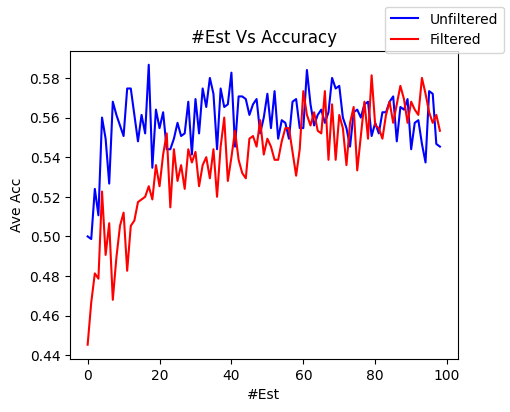

In [16]:
# Graph Accuracies
import pickle
try:
    with open('reacacc.pkl', 'rb') as file: 
        recacc = pickle.load(file)
        file.close()
    with open('reacacc_F.pkl', 'rb') as file: 
        recacc_F = pickle.load(file)
        file.close()
except:
    print("Failed")
    
fig4, ax4 = plt.subplots(1,1, figsize=(5, 4))  
ax4.plot(recacc,'b')
ax4.plot(recacc_F,'r')
fig4.legend(["Unfiltered", "Filtered"])
plt.title("#Est Vs Accuracy")
plt.xlabel("#Est")
plt.ylabel("Ave Acc")

In [15]:
#Save classifier using ideal number of estimators

clf = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
clf.fit(X_train, Y_train)
acc = clf.predict(X_test)
for i in range(len(acc)):
    acc[i] = acc[i] == Y_test[i]
acc = sum(acc)/len(acc)
print(acc)


clf = RandomForestClassifier(n_estimators = 50, class_weight='balanced')
clf.fit(X_train_F, Y_train_F)
acc = clf.predict(X_test_F)
for i in range(len(acc)):
    acc[i] = acc[i] == Y_test_F[i]
acc = sum(acc)/len(acc)
print(acc)

with open('./classifier.h', 'w') as file:
        file.write(port(clf, classname='RandomForestClassifier', tmp_file='./treeclf.json'))

0.4666666666666667
0.6


In [17]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle

# ------------------------------------------------------------------
# 1) Ensure training / test matrices exist
# ------------------------------------------------------------------
# X_train, X_test, Y_train, Y_test  – filtered data
# X_train_F, X_test_F, Y_train_F, Y_test_F – unfiltered/filtered variant
# (Assume they are defined earlier in the notebook.)

# ------------------------------------------------------------------
# 2) Global helper to run a CV evaluation for given hyper‑parameters
# ------------------------------------------------------------------

def cv_score(X, y, params, n_splits=3):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for tr_idx, val_idx in cv.split(X_scaled, y):
        X_tr, X_val = X_scaled[tr_idx], X_scaled[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        clf = RandomForestClassifier(
            **params,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
        )
        clf.fit(X_tr, y_tr)
        scores.append(accuracy_score(y_val, clf.predict(X_val)))
    return sum(scores) / len(scores)

# ------------------------------------------------------------------
# 3) Optuna objective – tunes four key hyperparameters
# ------------------------------------------------------------------

def make_objective(X, y):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
            "max_depth": trial.suggest_int("max_depth", 5, 40, step=5),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        }
        return cv_score(X, y, params)
    return objective

# ------------------------------------------------------------------
# 4) Run separate studies for unfiltered and filtered datasets
# ------------------------------------------------------------------

studies = {}
for tag, (X_tr, y_tr) in {
    "raw": (X_train, Y_train),
    "filtered": (X_train_F, Y_train_F),
}.items():
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
    )
    study.optimize(make_objective(X_tr, y_tr), n_trials=40, show_progress_bar=True)
    print(f"\n[{tag}] Best params → {study.best_trial.params} | CV Acc = {study.best_value:.4f}")
    studies[tag] = study

# ------------------------------------------------------------------
# 5) Save study results for later analysis / plotting
# ------------------------------------------------------------------

with open("rf_optuna_studies.pkl", "wb") as f:
    pickle.dump(studies, f)

# ------------------------------------------------------------------
# 6) Train final models on full training sets using the tuned params
# ------------------------------------------------------------------

best_models = {}
for tag, study in studies.items():
    X_tr, y_tr = (X_train, Y_train) if tag == "raw" else (X_train_F, Y_train_F)
    X_te, y_te = (X_test, Y_test) if tag == "raw" else (X_test_F, Y_test_F)
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)
    best_params = study.best_trial.params
    clf_best = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )
    clf_best.fit(X_tr_scaled, y_tr)
    test_acc = accuracy_score(y_te, clf_best.predict(X_te_scaled))
    print(f"[{tag}] Test Accuracy = {test_acc:.4f}")
    best_models[tag] = (clf_best, scaler)

# Now `best_models['raw']` and `best_models['filtered']` hold tuned models & scalers.


[I 2025-07-23 11:51:05,324] A new study created in memory with name: no-name-95b4654b-a65b-4fce-a92b-52a03b873259


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-07-23 11:51:05,837] Trial 0 finished with value: 0.5128205128205129 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5128205128205129.
[I 2025-07-23 11:51:06,021] Trial 1 finished with value: 0.49572649572649574 and parameters: {'n_estimators': 50, 'max_depth': 35, 'min_samples_split': 13, 'max_features': None}. Best is trial 0 with value: 0.5128205128205129.
[I 2025-07-23 11:51:07,255] Trial 2 finished with value: 0.4871794871794872 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 5, 'max_features': None}. Best is trial 0 with value: 0.5128205128205129.
[I 2025-07-23 11:51:07,901] Trial 3 finished with value: 0.47863247863247865 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 13, 'max_features': None}. Best is trial 0 with value: 0.5128205128205129.
[I 2025-07-23 11:51:08,540] Trial 4 finished with value: 0.5042735042735044 and parameters

[I 2025-07-23 11:51:33,447] A new study created in memory with name: no-name-63838b99-c191-4fac-932a-9e639cd15bb5


[I 2025-07-23 11:51:33,446] Trial 39 finished with value: 0.48717948717948717 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5128205128205129.

[raw] Best params → {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 15, 'max_features': 'sqrt'} | CV Acc = 0.5128


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-07-23 11:51:33,978] Trial 0 finished with value: 0.5042735042735043 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5042735042735043.
[I 2025-07-23 11:51:34,167] Trial 1 finished with value: 0.452991452991453 and parameters: {'n_estimators': 50, 'max_depth': 35, 'min_samples_split': 13, 'max_features': None}. Best is trial 0 with value: 0.5042735042735043.
[I 2025-07-23 11:51:35,300] Trial 2 finished with value: 0.47863247863247865 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 5, 'max_features': None}. Best is trial 0 with value: 0.5042735042735043.
[I 2025-07-23 11:51:35,955] Trial 3 finished with value: 0.48717948717948717 and parameters: {'n_estimators': 250, 'max_depth': 15, 'min_samples_split': 13, 'max_features': None}. Best is trial 0 with value: 0.5042735042735043.
[I 2025-07-23 11:51:36,616] Trial 4 finished with value: 0.4615384615384615 and parameters: